In [85]:

import numpy as np
import matplotlib.pyplot as plt
import STOM_higgs_tools
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D



ModuleNotFoundError: No module named 'scipy'

**Section 1** : Generating Data Points

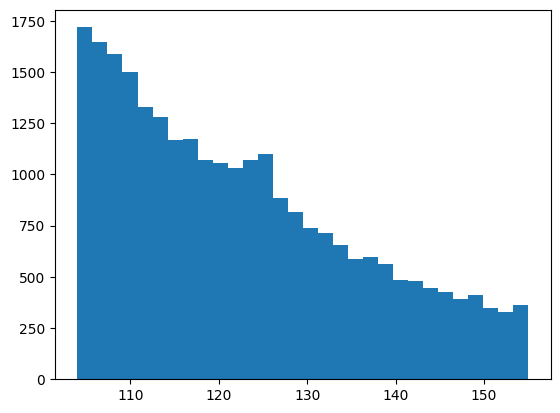

In [24]:
vals = STOM_higgs_tools.generate_data()
nbins= 30
mass_range=[104,155]
bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = nbins)
plt.show() 

**Statistical Uncertainties:** square root of the bins height


**Section 2a**: Max likelihood method

**Section 2b**: $\chi^2$ Minimisation

Create a range of A and lambda values. For each value of A (`A[i]`), cycle through every lambda value (`lamb[j]`), and calculate the chi-squared values. Check if chi-squared value is less than previous chi-squared values, if so, set these values of A and lambda as the optimum. 

Note that we only use the range `[104,120]` because we need to ignore the higgs boson bump. 

In [25]:
L=40#number of A and lambda values to check
A=np.linspace(5e4,10e4,L) #range of predicted A values
lamb=np.linspace(25,45,L) #range of predicted lambda values
pbar = tqdm(range(L**2))
chi_list_b=[1e6] #placeholder
mass_range_b=[104,120]
nbins_reduced=9
for i in range(L):
    for j in range(L):
        chi=STOM_higgs_tools.get_B_chi(vals,mass_range_b,nbins_reduced,A[i],lamb[j])*7
        if chi < np.min(chi_list_b):
            chi_min_b=chi
            lamb_opt_b=lamb[j]
            A_opt_b=A[i]
        chi_list_b=np.append(chi_list_b,chi)
        pbar.update(1)
print(f'lambda = {lamb_opt_b}, A = {A_opt_b}, minimum chi={chi_min_b}')

  0%|          | 0/1600 [00:00<?, ?it/s]

lambda = 29.102564102564102, A = 66666.66666666666, minimum chi=2.9035162765393694


In [27]:
chi_total = STOM_higgs_tools.get_B_chi(vals,[104,155],30,A_opt_b,lamb_opt_b)*28
print(chi_total)

117.45696703632576


In [28]:
L=40#number of A and lambda values to check
A=np.linspace(5e4,7e4,L) #range of predicted A values
lamb=np.linspace(20,40,L) #range of predicted lambda values
pbar = tqdm(range(L**2))
chi_list_s=[1e6] #placeholder
mass_range_s=[104,155]
nbins=30
for i in range(L):
    for j in range(L):
        chi=STOM_higgs_tools.get_B_chi(vals,mass_range_s,nbins,A[i],lamb[j]) * (nbins - 2)
        if chi < np.min(chi_list_s):
            chi_min=chi
            lamb_opt_s=lamb[j]
            A_opt_s=A[i]
        chi_list_s=np.append(chi_list_s,chi)
        pbar.update(1)
print(f'lambda = {lamb_opt_s}, A = {A_opt_s}, minimum chi={chi_min}')

  0%|          | 0/1600 [00:00<?, ?it/s]

lambda = 29.743589743589745, A = 59743.58974358974, minimum chi=107.63837648631558


In [29]:
chi_total = STOM_higgs_tools.get_B_chi(vals,[104,155],30,A_opt_b,lamb_opt_b)*(nbins-2)
print(chi_total)

117.45696703632576


**Section 3:** Goodness of fit

Find fit using optimised parameters:

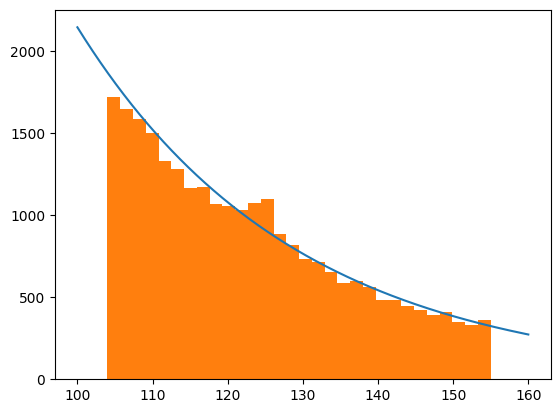

In [30]:
x=np.linspace(100,160,10000)
y=STOM_higgs_tools.get_B_expectation(x,A_opt_b,lamb_opt_b)
plt.plot(x,y)
bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range, bins = nbins)
plt.show() 

Chi-squared value for the *entire* range. Should be less than degrees of freedom `nbins-2`

In [31]:
chi_total = STOM_higgs_tools.get_B_chi(vals,[104,155],30,A_opt_b,lamb_opt_b)*(nbins -2)
print(chi_total)

117.45696703632576


**Section 4a**: Running the same $\chi^2$ minimisation, but *not* ignoring the Higgs signal. 

  0%|          | 0/1600 [00:00<?, ?it/s]

lambda = 24.102564102564102, A = 50000.0, minimum chi=537.279824870676


**Section 4b**: Finding mean $\chi^2$ value over many signal generations (background only)

In [14]:
A_opt = A_opt_b
lamb_opt = lamb_opt_b

simulations = 10000

chi_list = []

pbar = tqdm(range(simulations))
for i in range(simulations):
    vals=STOM_higgs_tools.generate_data()
    nbins=30
    mass_range =[104,155]
    chi=STOM_higgs_tools.get_B_chi(vals,mass_range,nbins,A_opt,lamb_opt)
    chi_list=np.append(chi_list,chi)
    pbar.update(1)

chi_range=[0,10]
chi_bins = 20
bin_heights, bin_edges, patches = plt.hist(chi_list, range = [0,10], bins = chi_bins)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Section 4c:** Finding mean $\chi^2$ value with various signal amplitudes

**Section 5a**: Signal Estimation using background parameterisation

Overlaying the signal

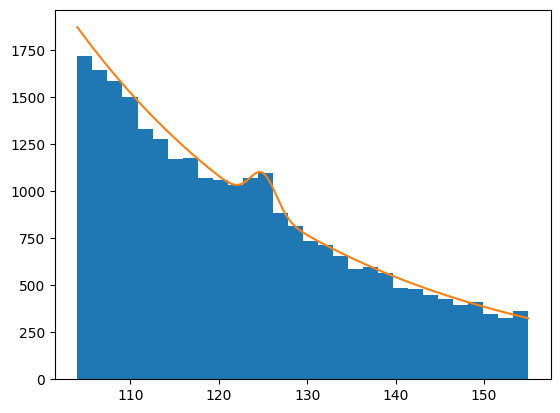

In [36]:
A_opt= A_opt_b
lamb_opt= lamb_opt_b
mass_range=[104,155]
nbins = 30

bin_heights, bin_edges, patches = plt.hist(vals, range = mass_range,bins = nbins)

signal_mean = 125 
signal_sig = 1.5
signal_amp = 700

x=np.linspace(104,155,10000)
y=STOM_higgs_tools.get_SB_expectation(x,A_opt,lamb_opt,signal_mean,signal_sig,signal_amp)
plt.plot(x,y)
plt.show() 

Finding $\chi^2$

In [38]:
half_bin_width = 0.5*(bin_edges[1] - bin_edges[0])
#recalculate ys_expected, but using half-bin widths
ys_expected = STOM_higgs_tools.get_SB_expectation(bin_edges+half_bin_width, A_opt, lamb_opt, signal_mean, signal_sig, signal_amp)
chi = 0

for i in range( len(bin_heights) ):
    chi_nominator = (bin_heights[i] - ys_expected[i])**2
    chi_denominator = ys_expected[i]
    chi += chi_nominator / chi_denominator

print(chi)

60.76862633303153


In [40]:

from scipy.stats import chi2

def calculate_p_value(chi_squared, sample_size):
    degrees_of_freedom = sample_size - 1
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    return p_value

# Example usage
chi_squared_value = chi
sample_size = 30

p_value = calculate_p_value(chi_squared_value, sample_size)
print("p-value:", p_value)


ModuleNotFoundError: No module named 'scipy'

**Section 5b:** Unknown Mass